In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
df = pd.read_csv('preprocessing/hdb_resale_prepared.csv')
df.drop(['block', 'street_name'], axis=1, inplace=True)

X = df.drop(columns=['resale_price'])  # Features
y = df['resale_price']                # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.dtypes)
print(y_train.dtypes)

town_BEDOK                           float64
town_BISHAN                          float64
town_BUKIT BATOK                     float64
town_BUKIT MERAH                     float64
town_BUKIT PANJANG                   float64
town_BUKIT TIMAH                     float64
town_CENTRAL AREA                    float64
town_CHOA CHU KANG                   float64
town_CLEMENTI                        float64
town_GEYLANG                         float64
town_HOUGANG                         float64
town_JURONG EAST                     float64
town_JURONG WEST                     float64
town_KALLANG/WHAMPOA                 float64
town_MARINE PARADE                   float64
town_PASIR RIS                       float64
town_PUNGGOL                         float64
town_QUEENSTOWN                      float64
town_SEMBAWANG                       float64
town_SENGKANG                        float64
town_SERANGOON                       float64
town_TAMPINES                        float64
town_TOA P

In [11]:
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for price prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [12]:
# Initialize the model
input_dim = X_train.shape[1]
model = build_model(input_dim)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\vigne\OneDrive\Documents\Projects\hdb stats\ResaleFlatPrices\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 97663066112.0000 - mae: 219563.8750 - val_loss: 4610110976.0000 - val_mae: 50883.7734
Epoch 2/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 6253716480.0000 - mae: 60098.2695 - val_loss: 3711784448.0000 - val_mae: 45380.9961
Epoch 3/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 5559841280.0000 - mae: 56546.4141 - val_loss: 3223438592.0000 - val_mae: 41710.9961
Epoch 4/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 5071385088.0000 - mae: 53621.7891 - val_loss: 2894850816.0000 - val_mae: 39316.3438
Epoch 5/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4808332800.0000 - mae: 52226.2852 - val_loss: 2654715904.0000 - val_mae: 37964.9453
Epoch 6/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4666769408.0000 - mae: 51467.1133 - val_loss: 2524157440.0000 - val_mae: 36978.4180
Epoch 7/100
3897/3897 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4629828608.0000 - mae: 51188.6719 - val_loss: 2544467

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae:.2f}")

model.save('models/hdb_price_prediction_model.keras')

1218/1218 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step


Mean Absolute Error on Test Set: 33968.54


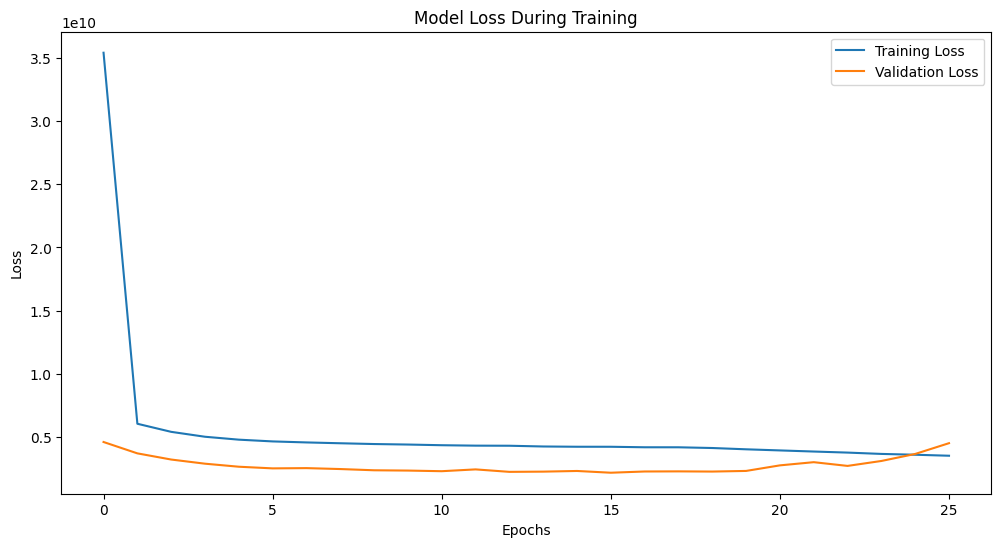

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

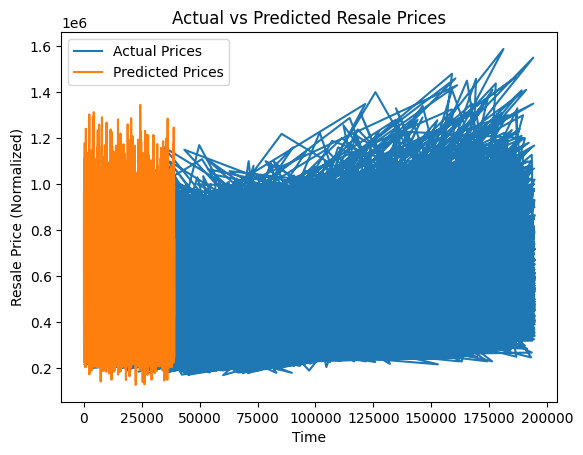

In [20]:
# Plot actual vs predicted prices
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('Actual vs Predicted Resale Prices')
plt.xlabel('Time')
plt.ylabel('Resale Price (Normalized)')
plt.legend()
plt.show()

In [19]:
import joblib
from tensorflow.keras.models import load_model

model = load_model('models/hdb_price_prediction_model.h5')
ohe = joblib.load('models/onehotencoder.pkl')
scaler = joblib.load('models/scaler.pkl')


# Define the feature columns used in the model
feature_columns = ['floor_area_sqm', 'remaining_lease_months', 'average_storey', 'year', 'month_num', 'distance_to_mrt']

# ---- Function to Process User Input and Predict Price ----
def predict_resale_price(user_input):
    # Step 1: Process the user input (ensure it matches the model's input requirements)
    # Example input: user_input = {'town': 'ANG MO KIO', 'flat_type': '3 ROOM', ...}

    # 1. Encode Categorical Variables
    categorical_cols = ['town', 'flat_type', 'flat_model']
    categorical_input = np.array([user_input[col] for col in categorical_cols]).reshape(1, -1)
    encoded_features = ohe.transform(categorical_input)  # One-hot encode

    # 2. Scale Numerical Features
    numerical_input = np.array([[
        user_input['floor_area_sqm'],
        user_input['remaining_lease_months'],
        user_input['average_storey'],
        user_input['year'],
        user_input['month_num'],
        user_input['distance_to_mrt']
    ]])

    scaled_features = scaler.transform(numerical_input)  # Standardize numerical features

    # 3. Combine the encoded and scaled features
    processed_input = np.concatenate([encoded_features, scaled_features], axis=1)

    # Step 2: Predict the resale price using the trained model
    predicted_price = model.predict(processed_input)
    return predicted_price[0][0]  # Return the predicted price

# ---- User Input ----
user_input = {
    'town': 'ANG MO KIO',
    'flat_type': '3 ROOM',
    'flat_model': 'New Generation',
    'floor_area_sqm': 67,
    'remaining_lease_months': 720,  # Example: 60 years * 12 months = 720 months
    'average_storey': 5,  # Example: Average of 4 to 6 storey range
    'year': 1980,
    'month_num': 1,
    'distance_to_mrt': 1.2  # Example: Distance in km to the nearest MRT station
}

# ---- Get Prediction ----
predicted_price = predict_resale_price(user_input)
print(f"The estimated resale price of the house is: SGD {predicted_price:,.2f}")

c:\Users\vigne\OneDrive\Documents\Projects\hdb stats\ResaleFlatPrices\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\vigne\OneDrive\Documents\Projects\hdb stats\ResaleFlatPrices\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
The estimated resale price of the house is: SGD 17,703,910.00
